# Bacterial Bomb - Model to Track Contamination

<img src="jupyter_cover_image.jpg">

**This model has been designed to track the fallout of a biological weapon that has been detonated on top of a building. The code used to build the model is detailed in this notebook.**

Docstrings detailing Classes, methods and functions can be found at ENTER LINK
Licesnce found at ENTER GITHUB LINK

---------

First import all the packages that will be needed to run the program. Instructions to install `pandas` and `seaborn` with Anaconda can be found here: 
https://anaconda.org/anaconda/pandas 
https://anaconda.org/anaconda/seaborn

In [4]:
import csv                      #to allow raster data to be read
import random                   #for random number generating
import matplotlib.pyplot as plt #for plotting spread 
import particle_framework       #the particle class created 
import pandas as pd             #for density map data frame
import time                     #to time spreading of particles
import seaborn as sns           #for creating density map 


## Build the `Particle` Class

Create the `Particle` Class which will be used as a framework and to initialise the particles. The class will enable the particles to spread either North, South, East or West depending on the directional probablities set. It will also enable them to rise up or fall down to the ground, again depending on the turbulance probabilities set. 

This code does not necessarily need to be run as the `particle_framework` import above already imported this Class. The codeblock can be unfolded to see the full code.

In [1]:
class Particle:
    """
    Particle Class:
        A class to give attributes and behaviours to an abstract particle.
        
    Constructor arguements:
        town -- 2D list containing the area particles will be in.
        particles -- a list of all the particles in the town.
        y -- y coord before init method sets particles' coods.
        x -- x coord before init method sets particles' coods.
    
    Particle characteristics:
        - height
        - y coordinate
        - x coordinate 
        
    Particle behaviours:
        - spread
        - turbulance
    
    """
    
    def __init__(self, town, particles, y, x):
        """
        Construct the initial states of the bacterial particle instance object.

        Parameters
        ----------
        town : list.
            2D containing lists of row data from imported file 'wind.raster'.
        particles : list.
            2D containing lists of all the particles y,x coords.
        y : int.
            Initial y location of every particle.
        x : int.
            Initial x location of every particle.

        Returns
        -------
        Particle.

        """
        
        #the initial starting point for each particle is at the bomb location
        self._y = 150 
        self._x = 50
            
        self._town = town  #giving every agent access to the map of the town
        self._particles = particles #every particle access to 'particles' list
        self._height = 75 #all particles initial height = building height 75m 
        
    
    # Accessor methods to protect variables, hidden vars
    def get_y (self):
        """Divert access of y int variable to a hidden int variable."""
        return self._y
    
    def get_x (self):
        """Divert access of x int variable to a hidden int variable."""
        return self._x  
    
    def get_height(self):
        """Divert access of height int variable to a hidden int variable."""
        return self._height
    
    
    # Mutator methods to protect changed vars
    def set_y (self, value):
        """Divert mutation of y int variable to a hidden int variable."""
        self._y = value
        
    def set_x (self, value):
        """Divert mutation of x int variable to a hidden int variable."""
        self._x = value 

    def set_height(self, value):
        """Divert mutation of height int variable to a hidden int variable."""
        self._height = value
        
    # Properties - y, x property attribues and docstrings
    y = property (get_y, set_y, "The particle 'y' coord") 
    x = property (get_x, set_x, "The particle 'x' coord") 
    height = property (get_height, set_height, "The height of the building")
    
        
    def __repr__(self):
        """Make printable string version of instance objects in particles list."""
        
        return str([self._x, self._y]) #used to print initial & moved particles
       
    
    
    def spread(self, p_east, p_west, p_north, p_south):
        """
        Random walk particles 1 step in one of four directions, depending on
        direction probabilities assigned by user.

        Parameters
        ----------
        p_east : int.
            Variable for percentage probability of particle moving east.
        p_west : int.
            Variable for percentage probability of particle moving west.
        p_north : int.
            Variable for percentage probability of particle moving north.
        p_south : int.
            Variable for percentage probability of particle moving south.

        Returns
        -------
        None.

        """
        
        chance = random.randint(1, 100) #select a random integer between 1-100 
        
        if chance <= p_east:
            self._x = self._x + 1 #move east 75% chance default or value entered
            
        elif (p_east < chance <= p_east + p_west):
            self._x = self._x - 1 #move west 5% chance default or value entered 
            
        elif (p_east + p_west < chance <= p_east + p_west + p_north):
            self._y = self._y + 1 #move north 10% chance default or value entered
        
        elif (p_east + p_west + p_north < chance <= p_east + p_west + p_north + p_south): 
            self._y = self._y - 1 #move south 10% chance default of value entered 
            
        #Town is non abstract landscape, particles cannot follow torus boundary
        #Create solid wall boundary, check if particle off edge & adjust
        if self._x < 0:   #if x, y hit 0, stop from going below 0 
            self._x = 0
        if self._y < 0:
            self._y = 0
        if self._x > 300:  #if x, y hit 299 (300x300 is town dimension),
            self._x = 300  #stop from going any higher
        if self._y > 300:
            self._y = 300
        
            
    
    def turbulance(self, p_rise, p_same, p_fall):
        """
        Random walk particles 1 step either up or down, depending on turbulance
        probabilities assigned by user, until all particles reach the ground.

        Parameters
        ----------
        p_rise : int.
            Variable for percentage probability of particle rising upwards.
        p_same : int.
            Variable for percentage probability of particle remaining at the 
            same level.
        p_fall : int.
            Variable for percentage probability of particle falling downwards.

        Returns
        -------
        None.

        """
        
        chance = random.randint(1, 100) #select a random integer between 1-100 
               
        if self._height >= 75: #for particles ABOVE the building height of 75m
            #particle rises, 20% default chance or value entered
            if chance <= p_rise:
                self._height = self._height + 1  
                
            #particle stays at same level, 10% chance or value entered   
            elif (p_rise < chance <= p_rise + p_same):
                self._height = self._height   
            
            #particle falls, 70% default chance of value entered    
            elif (p_rise + p_same < chance <= p_rise + p_same + p_fall):
                self._height = self._height - 1
                      
        elif (0 < self._height < 75):  #for particles BELOW the building height
            self._height = self._height - 1  #falls until hits the ground at 0m
                   

## Pull in the `wind.raster` data file and find out the bombing location

First the the raster data file needs to be read and processed. 

In [5]:
# Setting up town
f = open ('wind.raster', newline='') #read in data from raster file
#csv.reader gives data as list of list to be looped through
dataset = csv.reader (f, quoting=csv.QUOTE_NONNUMERIC) #converts no. to floats

town = [] #empty town list to add the rowlist elements (mutable)

for row in dataset:
    rowlist = [] #empty list to add each row as an element
    for value in row:
        rowlist.append (value) #adds each row's data as its own rowlist element
    town.append (rowlist)  #each rowlist added to environ list, 2D now 
f.close() 	#file closed after reading data

Now the location of the building where the bomb was detonated can be identified.

In [6]:
# Locating the bomb detonation point
counter = 0 #start a counter for the rows in the town list
for row in town: #both for loops to check through every value in the 2D list
    for value in row:
        if value != 0: #if the value is not equal to zero, then set bomb coords 
            bomb_x = row.index(value) #bomb x coord
            bomb_y = counter 
            #will print the coord of the only non zero pixel value (255)
            print("Coords of the building where bomb detonated:",(bomb_x, bomb_y))
    #step the row counter by 1 to loop through all rows until non zero found
    counter += 1

Coords of the building where bomb detonated: (50, 150)


Plot the raster data so that a map of the town can be outputted as a figure, with the bomb location marked.

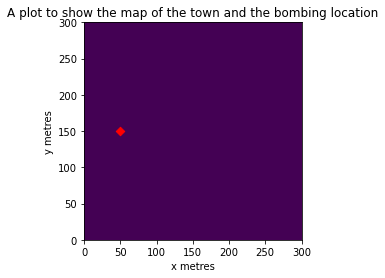

In [7]:
# Plotting the raster data
plt.ylim (0, 300) #setting graph axis 300x300 to match raster
plt.xlim (0, 300)
plt.title ('A plot to show the map of the town and the bombing location')
plt.xlabel('x metres') #graph axis labels, 1 pixel = 1 metre
plt.ylabel('y metres')
#mark the bomb location with a red diamond overlay 
plt.scatter (50, 150, color='red', marker=('D'))
#plotting map of the area/town and bombing location
plt.imshow(town) 

The figure outputted above should look like this image: 
<img src="outputs/initial_town.png">


## Calculate where the bacteria will end up

The **Major Model Parameters** need to be set. When the next few cells below are run, these parameters can be adjusted using sliders as desired. The codeblocks can be unfolded to reveal the code used to create these sliders. 

The default values are set to run the program for **5000 particles**, with the wind direction probabilities as:
**East = 75%, West = 5%, North = 10%, South = 10%**. To use these default values, run the code blocks and leave the sliders unchanged.

Please change the sliders only in the order that they are listed. If you decide to go back and change a percentage chosen, you will need to re-run the code blocks to update this change.

Ensure that as you are choosing the slider values, that the total does not go above 100%. \
For example, choosing East = 80% and West = 20%, then you will need to set North and South as 0%. 

In [8]:
# Major model parameters
num_of_particles = 5000

#Chances/probability of wind blowing particle in different directions
p_east = 75  #75 means 75% chance particle moves east each second/iteration 
p_west = 5   #NESW just need sum = 100
p_north = 10
p_south = 10

In [19]:
# Import modules needed for interactive sliders

import ipywidgets as widgets 
from IPython.display import display

In [22]:
# Set the number of particles

pslider = widgets.IntSlider(min=1, max=5000, step=1, description = 'Particles:', value = 5000)
pslider.value = num_of_particles
def on_change(v):
   global num_of_particles
   num_of_particles = v['new'] 
pslider.observe(on_change, names='value')
display(pslider)



IntSlider(value=5000, description='Particles:', max=5000, min=1)

In [11]:
#Probability of particles blowing East

eslider = widgets.IntSlider(min=1, max=100, step=1, description = 'East:', value = 75)
eslider.value = p_east
def e_change(v):
   global p_east
   p_east = v['new'] 
eslider.observe(e_change, names='value')
display(eslider)



IntSlider(value=75, description='East:', min=1)

In [12]:
#Probability of particles blowing West

wslider = widgets.IntSlider(min=1, max=100- p_east, step=1, description = 'West:', value = 5)
wslider.value = p_west
def w_change(v):
   global p_west
   p_west = v['new'] 
wslider.observe(w_change, names='value')
display(wslider)

IntSlider(value=5, description='West:', max=25, min=1)

In [13]:
# Probability of particles blowing North

nslider = widgets.IntSlider(min=1, max=100- p_east-p_west, step=1, description = 'North:', value = 10)
nslider.value = p_north
def n_change(v):
   global p_north
   p_north = v['new'] 
nslider.observe(n_change, names='value')
display(nslider)

IntSlider(value=10, description='North:', max=20, min=1)

In [14]:
# Probability of particles blowing South

sslider = widgets.IntSlider(min=1, max=100- p_east-p_west-p_north, step=1, description = 'South:', value = 10)
sslider.value = p_south
def s_change(v):
   global p_south
   p_south = v['new'] 
sslider.observe(s_change, names='value')
display(sslider)

IntSlider(value=10, description='South:', max=10, min=1)

The particles can now be created/initialised by using the `Particles` Class created in Section 1. The turbulance probabilities that cause the particles to either rise or fall to the ground have been fixed.

In [15]:
#Chances of wind turbulance effects 
p_rise = 20 #20% chance particle rises 1m per second (1 pixel per iteration)
p_same = 10 #particle stays at the same level
p_fall = 70 #just need sum = 100


particles = [] #empty list to add Partical class instances

print ("Initialising particles--") 
# Creating particles and adding to particles list

for i in range(num_of_particles): 
    y = 150
    x = 50
    #passing in data from town & particles list and y,x and appending to list
    particles.append (particle_framework.Particle(town, particles, y, x)) 

Initialising particles--


To move the particles that have just been created, the `spread` and `turbulance` methods from the `Particles` class will need to be used. This replicates the effects that the wind and turbulance, in a real town, would have on the particles. The bacteria particles spread either North, East, South or West. The turbulance means that particles may rise upwards, but they will all eventually fall down to the ground.

In [18]:
print ("Spreading bomb particles--")
# Particles spread across town either NESW directions and rise/fall 
start = time.perf_counter() #start clock to assess efficiency 
    
#Methods in Particles class act on every element in particles list
for i in range (num_of_particles): 
    
    #only run methods when the height of the particle is not 0 ie. not on ground
    seconds_count = 0 #to count the no of seconds/times while loop runs
    while particles[i].height != 0:
        
        seconds_count += 1 #increment by 1 every loop iteration, 1 iter = 1 sec
        particles[i].spread(p_east, p_west, p_north, p_south) #NESW movement
        particles[i].turbulance(p_rise, p_same, p_fall) #up/down movement

end = time.perf_counter() #end the timer for the calculating distances loops
print ("All particles have now settled on the ground")
print ("Time taken to calculate particles reaching ground = " + str (end - start))
print ("Time taken for particles to actually hit the ground in the town = "+str(seconds_count)+" seconds")

Spreading bomb particles--
All particles have now settled on the ground
Time taken to calculate particles reaching ground = 2.91937639999999
Time taken for particles to actually hit the ground in the town = 79 seconds


Plot these particles after spreading to visualise the movement.

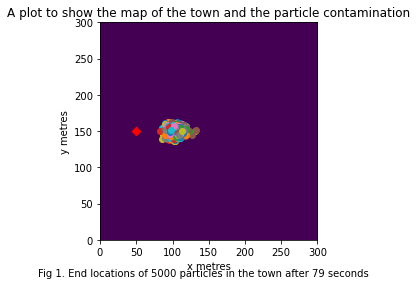

In [19]:
plt.ylim (0, 300) #setting graph axis 300x300 to match raster
plt.xlim (0, 300)
plt.title ('A plot to show the map of the town and the particle contamination')
plt.xlabel('x metres') #graph axis labels, 1 pixel = 1 metre
plt.ylabel('y metres')
#mark the bomb location with a red diamond overlay 
plt.scatter (50, 150, color='red', marker=('D'))
#plotting map of the area/town and bombing location
plt.imshow(town) 

for i in range (num_of_particles):
    #ith obj from particles list, using Particles Class to specify x, y coords
    plt.scatter (particles[i].x, particles[i].y) 
#figure caption
txt= "Fig 1. End locations of "+str(num_of_particles)+" particles in the town after "+str(seconds_count)+" seconds"
plt.figtext(0.5, 0.0001, txt, wrap=True, horizontalalignment='center', fontsize=10)
plt.show() 

If all the default major model parameters have remained unchanged, the figure outputted about should be similar to this:
<img src="outputs/town_after_spread.png">

Output the end locations of all the bacteria particles after they have reached the ground. The output file format is a `.txt` text file.

In [20]:
f = open("outputs/end_locations.txt",'w', newline='') #builtin open func to write end coords
for line in particles: #for every line in particles list
    f.write (repr(line)) #write as a string in the text file
f.close() #file closed after writting the coords

## Draw a density map of where all the bacteria end up as an image and display it

To draw a density map, first the x and y data of the particles are separated into two lists, and a disctionary is created with these. Using the `pandas` package, the dictionary forms the dataframe to be used for a density plot. The density plot is created and saved using the `seaborn` package.

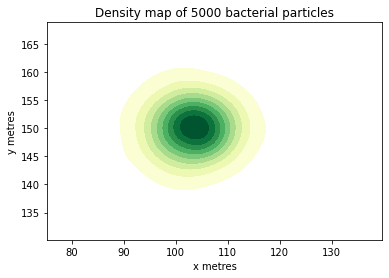

In [24]:
# Creating separate lists for all x & y end locations for density plot
all_x_data = []  #empty list for all x and y coords to go into
all_y_data = [] 
for i in range (num_of_particles):
    #for every particle, add its corresponding x coord/y coord into the list 
    all_x_data.append (particles[i].x)
    all_y_data.append (particles[i].y)

# Creating dictionary for x, y coords to use as pandas dataframe for density plot
d = {'x': all_x_data,'y': all_y_data} #creating the dictionary of 2 columns 

# Create pandas data frame from the dict and output density map
df = pd.DataFrame(d) #can check by calling d & df in console

plt.figure() #create a 2nd figure output
plt.title ('Density map of ' +str(num_of_particles)+' bacterial particles')
plt.xlabel('x metres') #graph axis labels, 1 pixel = 1 metre
plt.ylabel('y metres')

# Density plot using seaborn, darker green = very dense, yellow = less dense
density = sns.kdeplot(x= df.x, y= df.y, cmap='YlGn',shade=True,bw_method=0.5) 
density.figure.savefig("outputs/density_map.png") #save as an image file

If all the default major model parameters have remained unchanged, the figure outputted about should look like:
<img src="outputs/density_map.png">

## Save the density map to a file as text

To begin with, it has to be determined how many particles have landed on each pixel in the town map. The density is recorded by adding 1 to the town pixels where a particle has landed. The output `.txt` text file will have `0`'s where no particles are present and for example, a pixel value of `20` where 20 particles have landed at that location on the town. This gives a density map in a plain text format. 

In [23]:
# Save density map to file as text
for i in range (num_of_particles):  #for every particle
    #for every particles y, x coords in the town, add 1 to the town pixel.
    #the town pixel values will represent the no of particles/density there
    town[particles[i].y][particles[i].x] += 1 

f = open('outputs/density_map_text.txt', 'w', newline='') #create new text file
writer = csv.writer(f, delimiter=',', quoting=csv.QUOTE_NONNUMERIC)
#for every row in the town list, write that row to the new txt file
for line in town:
    writer.writerow(line) 
f.close() #close the file  